In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import re
import hashlib
from utils import which_set, wav2arr1s
%matplotlib inline

In [2]:
BASE_TRAIN_FOLDER_WAV = "wav_data/train/audio/"
BASE_TRAIN_FOLDER_SPEC = "spectrograms/"
RANDOM_EXAMPLE_FILE = "wav_data/train/audio/no/1706c35f_nohash_0.wav"

In [3]:
def wav2spec(wav_path, sample_rate=16000, use_log=False, use_mel=False, should_plot=False):
    _, samples = wav2arr1s(wav_path, sample_rate)
    spec = np.abs(librosa.stft(samples))

    if use_log:
        spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    if use_mel:
        spec = librosa.feature.melspectrogram(S=spec)
        
    if should_plot:
        sns.heatmap(spec)
        plt.show()
    
    #freq, times, spectrogram = signal.spectrogram(samples, sample_rate)
    return sample_rate, samples, spec

In [4]:
wav2spec(RANDOM_EXAMPLE_FILE)[1]

array([ 0.00085452,  0.00796533, -0.00634785, ...,  0.00167852,
        0.00158696,  0.00219733])

# Exploration du dataset

## Description générale du dataset
~66,000 fichiers de 1 seconde

### Nombre de représentants par classe

In [6]:
repartition = []
for label in os.listdir(BASE_TRAIN_FOLDER_WAV):
    if label.startswith('.'):
        continue
    repartition += [label] * len(list(x for x in os.listdir(os.path.join(BASE_TRAIN_FOLDER_WAV, label)) if not x.startswith('.')))

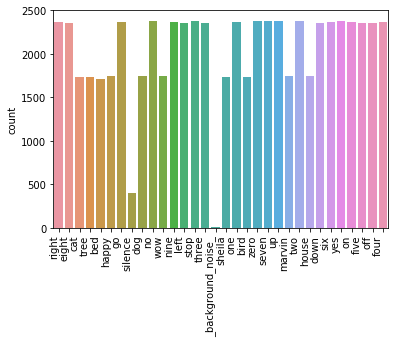

In [7]:
ax = sns.countplot(repartition)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

Les classes sont relativement équilibrées

### Cas particulier du "Background noise"
Un seul fichier long, à découper nous-même

In [8]:
background_noise_folder = os.path.join(BASE_TRAIN_FOLDER_WAV, '_background_noise_')
silence_folder = os.path.join(BASE_TRAIN_FOLDER_WAV, 'silence')
os.makedirs(silence_folder, exist_ok=True)
counter = 0
for filename in os.listdir(background_noise_folder):
    if not filename.endswith(".wav"):
        continue
    sample_rate, samples = wavfile.read(os.path.join(background_noise_folder, filename))
    for i in range(0, len(samples), sample_rate):
        part = samples[i:i+sample_rate]
        out_filename = os.path.join(silence_folder, f"{filename}_nohash_{i}.wav")
        wavfile.write(out_filename, sample_rate, part)
        counter += 1
print(f"Created {counter} silence files")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Created 402 silence files


Note : ~6 fois moins de fichiers que pour les autres classes, il pourrait être intéressant de générer plus de fichiers de "silence"

#### Data synthesis [TODO]

On découpe, change le pitch, deforme etc les background noise pour générer 2000 secondes et équilibrer les classes

#### Data mining [TODO]

On récupère plus de background noise sur l'internet

### Visualisation d'un exemple
WAV puis spectrogram

In [9]:
samples = librosa.load(RANDOM_EXAMPLE_FILE, sr=16000)[0]

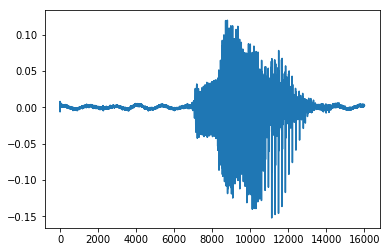

In [10]:
sns.lineplot(x=range(16000), y=samples)

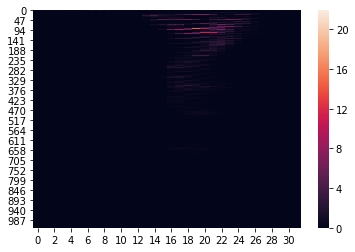

In [11]:
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True);

## Preprocessing

### Plusieurs types de spectrograms

Image plus caractéristique pour le "Mel power spectrogram" et l'application du log (plus proche du fonctionnement de l'oreille humaine)

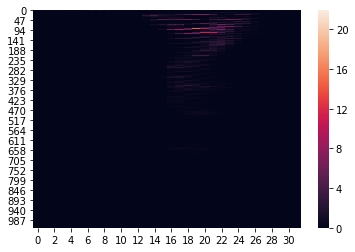

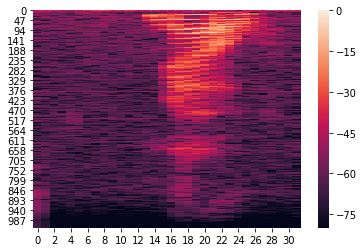

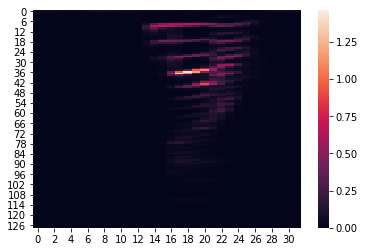

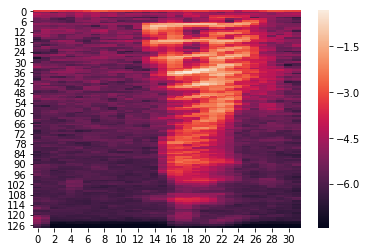

In [12]:
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True);
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True, use_log=True);
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True, use_mel=True);
wav2spec(RANDOM_EXAMPLE_FILE, should_plot=True, use_log=True, use_mel=True);

### Resampling
Comparaison d'audio avant et après resampling

In [13]:
samples16000 = librosa.load(RANDOM_EXAMPLE_FILE, sr=16000)[0]
ipd.Audio(samples16000, rate=16000)

In [14]:
samples8000 = librosa.load(RANDOM_EXAMPLE_FILE, sr=8000)[0]
ipd.Audio(samples8000, rate=8000)

Les deux sont tout aussi compréhensibles, la différence est minime, mais le poids est divisé par deux.

Comparaison des spectrograms après resampling

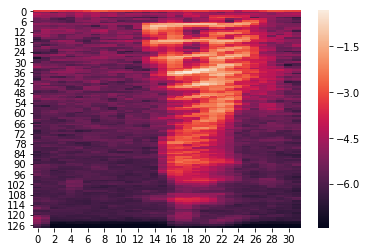

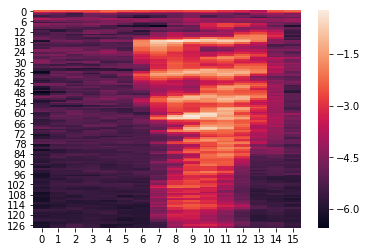

In [15]:
wav2spec(RANDOM_EXAMPLE_FILE, sample_rate=16000, should_plot=True, use_log=True, use_mel=True);
wav2spec(RANDOM_EXAMPLE_FILE, sample_rate=8000, should_plot=True, use_log=True, use_mel=True);

# Pre-processing du dataset

On choisit :
- taille des données ?
- mel-log-spectrogram
- normalisation du volume
- suppression du bruit + padding 
- data de synthèse ?
- resampling à 8k au lieu de 16k ? (suppression de bruit et données plus légères)

Pour chacun des x labels, on créé un array numpy en 3D : nombre de samples dans le dataset, frequence (=129), temps (=71)

In [16]:
RESAMPLE_RATE = 8000
USE_LOG = True
USE_MEL = True

In [17]:
SPEC_SHAPE = wav2spec(RANDOM_EXAMPLE_FILE, sample_rate=RESAMPLE_RATE, use_log=USE_LOG, use_mel=USE_MEL)[2].shape

In [18]:
SPEC_SHAPE

(128, 16)

In [19]:
def generate_subset(set_name, label, validation_percentage=10, testing_percentage=10):
    label_folder_wav = os.path.join(BASE_TRAIN_FOLDER_WAV, label)
    os.makedirs(os.path.join(BASE_TRAIN_FOLDER_SPEC, set_name), exist_ok=True)
    label_files = [
        filename for filename in os.listdir(label_folder_wav) 
        if filename.endswith('.wav') and which_set(filename, validation_percentage, testing_percentage) == set_name
    ]
    
    label_specs = np.zeros((len(label_files), *SPEC_SHAPE), dtype=np.float16)
    for i, filename in tqdm(enumerate(label_files), desc=f"{label} ({set_name})"):
        sample_rate, samples, spectrogram = wav2spec(
            os.path.join(label_folder_wav, filename), 
            sample_rate=RESAMPLE_RATE, 
            use_log=USE_LOG, 
            use_mel=USE_MEL
        )
        label_specs[i,:,:] = spectrogram.astype(np.float16)  # using float16 saves a lot of space (-75%)
    np.save(os.path.join(BASE_TRAIN_FOLDER_SPEC, set_name, label), label_specs)

In [20]:
for label in os.listdir(BASE_TRAIN_FOLDER_WAV):
    if label.startswith('.') or label.startswith('_'):
        print(f"Ignoring folder '{label}'")
        continue
    
    generate_subset('train', label)
    generate_subset('validation', label)
    generate_subset('testing', label)

right (train): 1852it [00:20, 91.39it/s] 
right (validation): 256it [00:02, 104.70it/s]
right (testing): 259it [00:02, 98.82it/s]
eight (train): 1852it [00:21, 86.62it/s]
eight (validation): 243it [00:02, 90.32it/s] 
eight (testing): 257it [00:02, 90.89it/s]
cat (train): 1399it [00:15, 90.73it/s]
cat (validation): 168it [00:01, 91.87it/s]
cat (testing): 166it [00:02, 80.58it/s]
tree (train): 1374it [00:16, 82.73it/s]
tree (validation): 166it [00:01, 106.93it/s]
tree (testing): 193it [00:01, 98.32it/s] 
bed (train): 1340it [00:15, 87.72it/s]
bed (validation): 197it [00:02, 86.55it/s]
bed (testing): 176it [00:01, 105.52it/s]
happy (train): 1373it [00:14, 92.13it/s]
happy (validation): 189it [00:02, 94.11it/s] 
happy (testing): 180it [00:02, 85.66it/s]
go (train): 1861it [00:21, 87.45it/s]
go (validation): 260it [00:02, 94.05it/s] 
go (testing): 251it [00:02, 106.50it/s]
silence (train): 15it [00:00, 148.31it/s]

Ignoring folder '.DS_Store'


silence (train): 402it [00:02, 150.67it/s]
silence (validation): 0it [00:00, ?it/s]
silence (testing): 0it [00:00, ?it/s]
dog (train): 1396it [00:14, 91.41it/s]
dog (validation): 170it [00:01, 88.35it/s]
dog (testing): 180it [00:02, 89.04it/s]
no (train): 1853it [00:21, 87.94it/s]
no (validation): 270it [00:02, 91.49it/s] 
no (testing): 252it [00:02, 98.58it/s] 
wow (train): 1414it [00:16, 83.99it/s]
wow (validation): 166it [00:01, 91.02it/s]
wow (testing): 165it [00:02, 69.85it/s]
nine (train): 1875it [00:19, 95.90it/s]
nine (validation): 230it [00:02, 98.24it/s] 
nine (testing): 259it [00:03, 78.90it/s]
left (train): 1839it [00:24, 74.68it/s]
left (validation): 247it [00:02, 101.58it/s]
left (testing): 267it [00:03, 94.46it/s]
stop (train): 1885it [00:24, 60.19it/s]
stop (validation): 246it [00:02, 97.51it/s] 
stop (testing): 249it [00:03, 67.90it/s]
three (train): 1841it [00:29, 62.87it/s]
three (validation): 248it [00:04, 52.83it/s]
three (testing): 267it [00:03, 81.95it/s]
sheila 

Ignoring folder '_background_noise_'


sheila (train): 1372it [00:19, 68.66it/s]
sheila (validation): 176it [00:02, 59.23it/s]
sheila (testing): 186it [00:02, 68.12it/s]
one (train): 1892it [00:24, 77.80it/s]
one (validation): 230it [00:02, 105.79it/s]
one (testing): 248it [00:02, 87.89it/s]
bird (train): 1411it [00:17, 78.43it/s]
bird (validation): 162it [00:01, 96.86it/s]
bird (testing): 158it [00:01, 90.10it/s]
zero (train): 1866it [00:22, 83.07it/s]
zero (validation): 260it [00:02, 91.00it/s]
zero (testing): 250it [00:02, 87.94it/s]
seven (train): 1875it [00:24, 76.45it/s]
seven (validation): 263it [00:03, 76.97it/s]
seven (testing): 239it [00:02, 104.81it/s]
up (train): 1843it [00:24, 75.82it/s]
up (validation): 260it [00:03, 76.02it/s]
up (testing): 272it [00:03, 84.81it/s]
marvin (train): 1424it [00:17, 89.94it/s]
marvin (validation): 160it [00:02, 78.17it/s]
marvin (testing): 162it [00:02, 74.77it/s]
two (train): 1873it [00:22, 82.08it/s]
two (validation): 236it [00:02, 81.59it/s]
two (testing): 264it [00:03, 68.22i